In [1]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from training.train_simplified_snn import train_simplified_snn
from constants import NUMBER_INPUT_NEURONS, NUMBER_HIDDEN_NEURONS, NUMBER_OUTPUT_NEURONS, BETA, TIME_STEPS, NUMBER_HIDDEN_LAYERS

/home/mark/anaconda3/envs/whk-snn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
best_sparsity = 0
best_number_hidden_layer = 2
best_number_hidden_neurons = 1000

best_sparsity_model = ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=BETA,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYERS,
                                                 sparsity=0)

best_number_hidden_layer_model = ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=NUMBER_HIDDEN_NEURONS,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=BETA,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=best_number_hidden_layer,
                                                 sparsity=0)

best_number_hidden_neurons_model = ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                 number_hidden_neurons=best_number_hidden_neurons,
                                                 number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                 beta=BETA,
                                                 time_steps=TIME_STEPS,
                                                 number_hidden_layers=NUMBER_HIDDEN_LAYERS,
                                                 sparsity=0)

In [ ]:
num_epochs = 30

train_simplified_snn(best_sparsity_model, 
                     num_epochs=num_epochs, 
                     save_model='./models/best_sparsity', 
                     save_plots='./output/experiments_sparsity/best_sparsity', 
                     additional_output_information={
                         'num_hidden_neurons': NUMBER_HIDDEN_NEURONS,
                         'num_hidden_layer': NUMBER_HIDDEN_LAYERS,
                         'sparsity': best_sparsity
                     },
                     output_file_path='./output/experiments_sparsity/best_sparsity.json')

train_simplified_snn(best_number_hidden_layer_model, 
                     num_epochs=num_epochs, 
                     save_model='./models/best_number_hidden_layer', 
                     save_plots='./output/experiments_multiple_hidden_layer/best_number_hidden_layer', 
                     additional_output_information={
                         'num_hidden_neurons': NUMBER_HIDDEN_NEURONS,
                         'num_hidden_layer': best_number_hidden_layer,
                         'sparsity': 0
                     },
                     output_file_path='./output/experiments_multiple_hidden_layer/best_number_hidden_layer.json')

train_simplified_snn(best_number_hidden_neurons_model, 
                     num_epochs=num_epochs, 
                     save_model='./models/best_number_hidden_neurons', 
                     save_plots='./output/experiments_number_hidden_neurons/best_number_hidden_neurons', 
                     additional_output_information={
                         'num_hidden_layer': NUMBER_HIDDEN_LAYERS,
                         'num_hidden_neurons': best_number_hidden_neurons,
                         'sparsity': 0
                     },
                     output_file_path='./output/experiments_number_hidden_neurons/best_number_hidden_neurons.json')

Epoch: 0
loss 235.34234619140625
accuracy 0.17857142857142858
Epoch: 1
loss 180.50778198242188
accuracy 0.4642857142857143
Epoch: 2
loss 161.14036560058594
accuracy 0.5714285714285714
Epoch: 3
loss 142.60470581054688
accuracy 0.6785714285714286
Epoch: 4
loss 142.8384552001953
accuracy 0.7857142857142857
Epoch: 5
loss 138.13243103027344
accuracy 0.8214285714285714
Epoch: 6


In [ ]:
import torch
import copy

best_sparsity_model_trained = copy.deepcopy(best_sparsity_model)
best_sparsity_model_trained.load_state_dict(torch.load('./models/best_sparsity.pth'))

best_number_hidden_neurons_model_trained = copy.deepcopy(best_number_hidden_neurons_model)
best_number_hidden_neurons_model_trained.load_state_dict(torch.load('./models/best_number_hidden_neurons.pth'))

best_number_hidden_layer_model_trained = copy.deepcopy(best_number_hidden_layer_model)
best_number_hidden_layer_model_trained.load_state_dict(torch.load('./models/best_number_hidden_layer.pth'))

<All keys matched successfully>

In [ ]:
import torch
from util.utils import get_device
from torch.utils.data import DataLoader
from tonic import datasets, transforms

selection_index = 0
device = get_device()

frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=TIME_STEPS
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=32)

data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]


In [ ]:
def get_spk_matrices(data, model, selection_index):
    spk_recs, _ = model(data)

    output_spk_rec = spk_recs[-1][:, selection_index, :]
    hidden_spk_rec = [hidden_spk_rec[:, selection_index, :].detach() for hidden_spk_rec in spk_recs[:-1]]

    return [x_selected, *hidden_spk_rec, output_spk_rec.detach()]

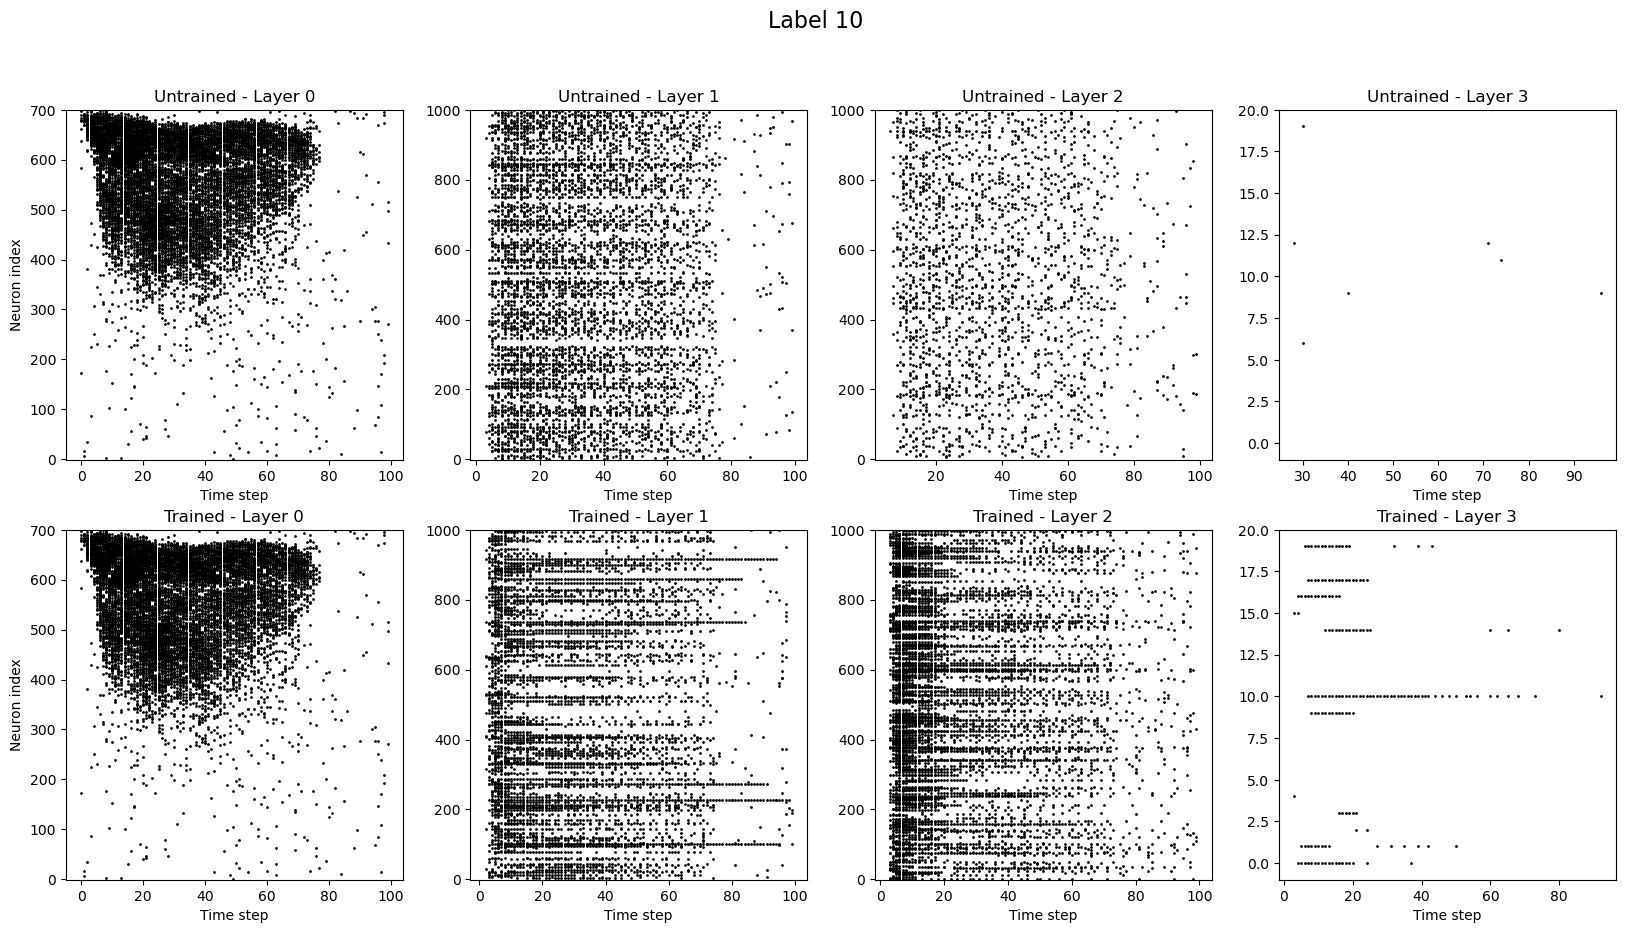

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spike_matrices_untrained = get_spk_matrices(data, best_sparsity_model, selection_index)
spike_matrices_trained = get_spk_matrices(data, best_sparsity_model_trained, selection_index)

fig, axes = plt.subplots(2, len(spike_matrices_untrained), figsize=(20, 10))

fig.suptitle(f"best_sparsity Label {y_selected}", fontsize=16)

for index in range(len(spike_matrices_untrained)):
    spike_matrix_np = spike_matrices_untrained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_untrained = axes[0, index]
    ax_untrained.scatter(times, neurons, s=1, color='black')
    ax_untrained.set_title(f"Untrained - Layer {index}")
    ax_untrained.set_xlabel("Time step")
    ax_untrained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_untrained.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_trained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_trained = axes[1, index]
    ax_trained.scatter(times, neurons, s=1, color='black')
    ax_trained.set_title(f"Trained - Layer {index}")
    ax_trained.set_xlabel("Time step")
    ax_trained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_trained.set_ylabel("Neuron index")